# Step2: Using scanpy to preprocess the scRNAseq data

## Importing libraries

In [1]:
import os
import sys
import subprocess
import pycisTopic
pycisTopic.__version__
import subprocess
from pycisTopic.cistopic_class import *
from pycisTopic.utils import *
from pycisTopic.lda_models import * 
import anndata as ad
import scanpy as sc

2024-11-28 16:17:27,957	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Creating the merged adata object

In [2]:
# Determine the folder in which the code is executed
WORKING_DIR = os.getcwd()
sys.path.append(os.path.abspath( WORKING_DIR))

# Run the params codes
%run -i ../../globalParams.py #GlobalParams
%run -i ../../sampleParams.py #sampleParams
%run -i ./analysisParams.py #AnalysisParams

In [3]:
# Get a list of all directories in the specified path
directories = [d for d in os.listdir(PATH_TO_VELOCITY_FOLDER) if os.path.isdir(os.path.join(PATH_TO_VELOCITY_FOLDER, d))]
print(directories)

['CSS1', 'CSS23', 'CSS4', 'CSS7', 'CSS25', 'CSS27', 'CSS21', 'CSS19', 'CSS13', 'CSS16', 'CSS10']


In [4]:
# Import them and merge them in a list
import scanpy as sc

adata_CSS1 = sc.read_10x_mtx(
    os.path.join( PATH_TO_VELOCITY_FOLDER, "CSS1/CSS1_filtered_feature_bc_matrix"),
    var_names = "gene_symbols"
)


In [5]:
import os
import scanpy as sc
import anndata as ad

# Dictionary to store AnnData objects with their respective names
adata_dict = {}

# Loop over directories and load the AnnData object
for dir_name in directories:
    # Construct the full path to the 10x matrix for each directory
    path_to_matrix = os.path.join(PATH_TO_VELOCITY_FOLDER, f"{dir_name}/{dir_name}_filtered_feature_bc_matrix")
    
    # Read the AnnData object
    adata = sc.read_10x_mtx(
        path_to_matrix,
        var_names="gene_symbols"
    )
    
    # Store in the dictionary with the directory name
    adata_dict[dir_name] = adata

# Add an identifier (like the directory name) as a column in `obs` of each AnnData object
for name, adata in adata_dict.items():
    adata.obs['sample'] = name  # Add the directory name as a 'sample' identifier in the observation data


In [6]:
# Merge all the AnnData objects into one using the sample name to track origins
merged_adata = ad.concat(adata_dict, label='sample', join='outer', merge='same',  index_unique="_" )

# Optional: Verify the shape of the merged object and show the first few rows
print(merged_adata)


AnnData object with n_obs × n_vars = 71240 × 36601
    obs: 'sample'
    var: 'gene_ids', 'feature_types'


In [7]:
#Example of cell names
merged_adata.obs_names

Index(['AAACAGCCATAACGGG-1_CSS1', 'AAACCGAAGCGCATTG-1_CSS1',
       'AAACCGAAGGCGTAAA-1_CSS1', 'AAACCGAAGGTCGATT-1_CSS1',
       'AAACCGAAGTGAGCGG-1_CSS1', 'AAACCGAAGTTAGCTA-1_CSS1',
       'AAACCGCGTCACGGAT-1_CSS1', 'AAACCGCGTGGATTAT-1_CSS1',
       'AAACCGCGTGGCTTCC-1_CSS1', 'AAACCGGCACCCACAG-1_CSS1',
       ...
       'TTTAGCAAGTTTGTCT-1_CSS10', 'TTTCACCCAGTAATAG-1_CSS10',
       'TTTCATCAGACACTTA-1_CSS10', 'TTTCATCAGTAGCGGG-1_CSS10',
       'TTTCGTCCAAGGATTA-1_CSS10', 'TTTGCGACAACTAGAA-1_CSS10',
       'TTTGCGACAATAGCAA-1_CSS10', 'TTTGCGGAGTAAGTCC-1_CSS10',
       'TTTGGCTGTGCATTAG-1_CSS10', 'TTTGTGAAGTAGAGGC-1_CSS10'],
      dtype='object', length=71240)

In [8]:
import pandas as pd
cell_data = pd.read_csv(PATH_TO_CELLDATA_CSV, index_col = 0)
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,cell_type,sex,smoker,sample,nCount_peaks,...,wsnn_res.0.8,wsnn_res.0.9,wsnn_res.1,wsnn_res.0.2_1,wsnn_res.0.4_1,Fine_Annotation_WNN,peaks_snn_res.0.3_1,Annotation_Peaks_RNA,Annotation_Peaks_GA,Coarse_Annotation_WNN
CSS1_AAACCGCGTGGATTAT-1,BS840,2061,1111,19916,7897,Tumor_NK_cells,male,40 py,CSS1,11495,...,1,1,1,1,2,NK3_GZMK,2,NaN,NK_SLC1A2,NK_ITGA1
CSS1_AAACCGGCAGGCTTCG-1,BS840,2148,1139,15845,6484,Tumor_NK_cells,male,40 py,CSS1,9323,...,0,0,0,2,1,NK1_FGFBP2,7,ILC3,ILC3,NK1
CSS1_AAACGCGCAAGATTCT-1,BS840,1863,1127,6887,3222,Tumor_NK_cells,male,40 py,CSS1,4157,...,8,12,13,2,5,NK1_CCL4,8,NaN,NK_HSPA1B,NK1
CSS1_AAACGGATCCTTGAGG-1,BS840,1957,1136,16083,6556,Tumor_NK_cells,male,40 py,CSS1,9530,...,6,9,8,3,6,NK2_XCL1,4,NaN,NK2_IL7R,NK2
CSS1_AAAGCAAGTTGTTGTC-1,BS840,1802,1035,14306,5994,Tumor_NK_cells,male,40 py,CSS1,8418,...,1,1,1,1,2,NK3_GZMK,2,NaN,NK_SLC1A2,NK_ITGA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CSS27_TTTGTCTAGTTCCCAC-1,BS1322,6158,2224,38961,14601,Tumor_NK_cells,male,10 py,CSS27,24575,...,4,4,4,3,6,NK2_XCL1,2,NaN,NK_SLC1A2,NK2
CSS27_TTTGTGAAGGACCTTG-1,BS1322,4324,1712,50263,18139,Tumor_NK_cells,male,10 py,CSS27,30811,...,9,10,11,5,10,ILC3,7,ILC3,ILC3,ILC3
CSS27_TTTGTGGCAAAGCGCA-1,BS1322,2952,1364,33911,12534,Tumor_NK_cells,male,10 py,CSS27,20597,...,2,2,2,1,4,NK3_CAMK4,3,NK_CAMK4,NK_CAMK4,NK_ITGA1
CSS27_TTTGTGGCAGCCAGAA-1,BS1322,3056,1560,29646,11396,Tumor_NK_cells,male,10 py,CSS27,18087,...,1,1,1,1,2,NK3_GZMK,2,NaN,NK_SLC1A2,NK_ITGA1


In [9]:
cell_data.index

Index(['CSS1_AAACCGCGTGGATTAT-1', 'CSS1_AAACCGGCAGGCTTCG-1',
       'CSS1_AAACGCGCAAGATTCT-1', 'CSS1_AAACGGATCCTTGAGG-1',
       'CSS1_AAAGCAAGTTGTTGTC-1', 'CSS1_AAAGCCCGTGCTGTAA-1',
       'CSS1_AAAGCCGCACCTAAGC-1', 'CSS1_AAAGCCGCATCAGCAC-1',
       'CSS1_AAAGCCGCATCGTTCT-1', 'CSS1_AAAGCGGGTACCGGAT-1',
       ...
       'CSS27_TTTGGTGCATGAAGTA-1', 'CSS27_TTTGTCCCACGTAAGG-1',
       'CSS27_TTTGTCCCATGGCCCA-1', 'CSS27_TTTGTCTAGATGCCTG-1',
       'CSS27_TTTGTCTAGTTACCGG-1', 'CSS27_TTTGTCTAGTTCCCAC-1',
       'CSS27_TTTGTGAAGGACCTTG-1', 'CSS27_TTTGTGGCAAAGCGCA-1',
       'CSS27_TTTGTGGCAGCCAGAA-1', 'CSS27_TTTGTGTTCCTCCCTC-1'],
      dtype='object', length=29411)

In [10]:
# Function to modify the cell_data.index format
def reformat_index(index):
    # Split the current index string (e.g., 'CSS1_AAACCGCGTGGATTAT-1')
    # into the sample ID ('CSS1') and the cell barcode ('AAACCGCGTGGATTAT-1')
    return [f"{idx.split('_')[1]}_{idx.split('_')[0]}" for idx in index]

# Apply the reformatting function to the index
cell_data.index = reformat_index(cell_data.index)

In [11]:
len(list(set(merged_adata.obs_names) & set(cell_data.index)))

29411

In [12]:
# Keep intersection of adata and cell_data
adata = merged_adata[list(set(merged_adata.obs_names) & set(cell_data.index))].copy()

# Add the metadata
adata.obs = cell_data.loc[adata.obs_names]

In [13]:
# Calculate QC
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [14]:
# Data normalization
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,cell_type,sex,smoker,sample,nCount_peaks,...,wsnn_res.0.4_1,Fine_Annotation_WNN,peaks_snn_res.0.3_1,Annotation_Peaks_RNA,Annotation_Peaks_GA,Coarse_Annotation_WNN,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
GCCACACAGACAGGTA-1_CSS21,BS1314,1894,1046,36650,13044,Tumor_NK_cells,female,25 py,CSS21,21311,...,9,ILC1,6,ILC1,ILC1,ILC1,1046,1894.0,133.0,7.022175
ACCTCACTCGGGATTT-1_CSS16,BS1198,1689,981,1610,750,Tumor_NK_cells,female,30 py,CSS16,872,...,7,NK_ENTPD1,5,NK_ENTPD1,NK_ENTPD1,NK_ITGA1,981,1689.0,222.0,13.143871
TTGGCGGGTTCCTCCT-1_CSS13,BS1175,2583,1372,3870,1831,Tumor_NK_cells,female,14 py,CSS13,2268,...,5,NK1_CCL4,1,NaN,NK1_CX3CR1,NK1,1372,2583.0,129.0,4.994193
TCTTAGTTCGATTTAG-1_CSS16,BS1198,4490,1955,10827,4828,Tumor_NK_cells,female,30 py,CSS16,6065,...,1,NK1_FGFBP2,1,NaN,NK1_CX3CR1,NK1,1955,4490.0,204.0,4.543430
GAACCTTAGCCTGGTA-1_CSS27,BS1322,3827,1647,33073,12048,Tumor_NK_cells,male,10 py,CSS27,20197,...,9,ILC1,6,ILC1,ILC1,ILC1,1647,3827.0,49.0,1.280376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACCTGATCAGCAAAG-1_CSS13,BS1175,2687,1357,11749,4648,Tumor_NK_cells,female,14 py,CSS13,6629,...,5,NK1_CCL4,1,NaN,NK1_CX3CR1,NK1,1357,2687.0,374.0,13.918869
TCGCGCACAGGCGAGT-1_CSS21,BS1314,1739,1006,13086,5541,Tumor_NK_cells,female,25 py,CSS21,7553,...,9,ILC1,6,ILC1,ILC1,ILC1,1006,1739.0,66.0,3.795285
CAGCTAAGTTGGTGAC-1_CSS21,BS1314,1591,939,17040,6984,Tumor_NK_cells,female,25 py,CSS21,9758,...,1,NK1_FGFBP2,1,NaN,NK1_CX3CR1,NK1,939,1591.0,64.0,4.022627
TAGTGGCGTGTTTCAC-1_CSS16,BS1198,1835,1038,16779,6889,Tumor_NK_cells,female,30 py,CSS16,9352,...,2,NK3_GZMK,2,NaN,NK_SLC1A2,NK_ITGA1,1038,1835.0,243.0,13.242507


/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


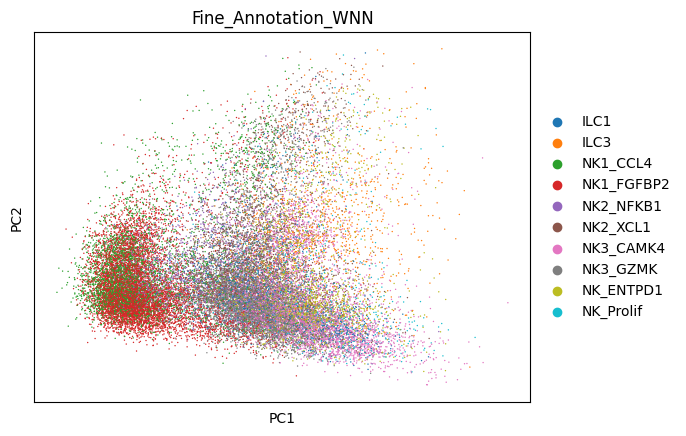

In [16]:
# PCA
sc.tl.pca(adata)
sc.pl.pca(adata, color = CELL_TYPE_COLNAME)

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


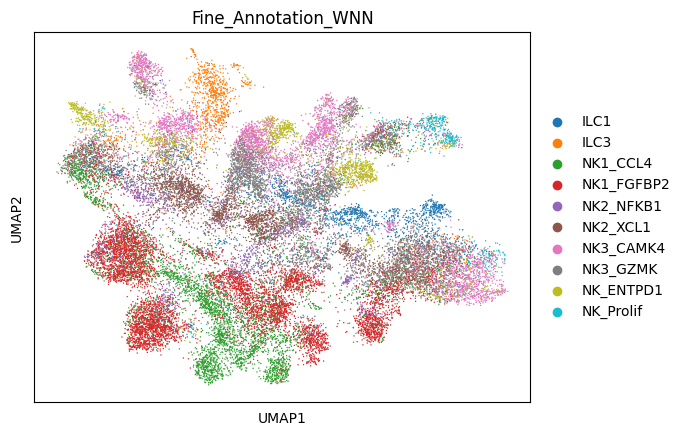

In [17]:
# Neigbors and umap
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = CELL_TYPE_COLNAME)


In [19]:
adata.write(os.path.join(PATH_ANALYSIS_OUTPUT , "adata.h5ad"))